# Feature Analysis



In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

import warnings  # Base category for warnings triggered during the process of importing a module (ignored by default)
warnings.filterwarnings('ignore')  # here we prescribe the action in case of an error.

data = pd.read_csv('../data/train.csv')


In [2]:
data['Credit_History'].replace({1: 'Y', 0: 'N'}, inplace=True)
data['Credit_History'] = data['Credit_History'].fillna('DK')
data['Married'] = data['Married'].fillna('DK')
data['Gender'] = data['Gender'].fillna('DK')
data['Self_Employed'] = data['Self_Employed'].fillna('DK')
Loancols = [ 'LoanAmount',  'Loan_Amount_Term']
data.dropna(subset=Loancols, inplace=True)

For feature anañysis we replace the categorical target by a numerical target.

We study the relevance of the categorical variables

In [3]:
data['Loan_Status_Numeric'] = data['Loan_Status'].apply(lambda x: 1 if x == 'Y' else 0)

target = "Loan_Status_Numeric"
cat_vars = data.select_dtypes(include="object").columns

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.values.sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))


cramer=[]
for var in cat_vars.drop(['Loan_ID','Loan_Status']):
    table = pd.crosstab(data[var], data[target])
    chi2, p, dof, expected = chi2_contingency(table)
    print(var)
    print("Chi-square:", chi2)
    print("p-value:", p)

    cramers_v_value = cramers_v(table)
    print("Cramer's V:", cramers_v_value)
    cramer.append([var ,cramers_v_value])



Gender
Chi-square: 0.9527918591076979
p-value: 0.6210175543623843
Cramer's V: 0.040600847552552846
Married
Chi-square: 6.025633032709544
p-value: 0.049153043267292945
Cramer's V: 0.10210274553030492
Dependents
Chi-square: 3.208120772439017
p-value: 0.3606365914061768
Cramer's V: 0.07528650544311191
Education
Chi-square: 2.333600451666894
p-value: 0.1266087355857626
Cramer's V: 0.06354031022622682
Self_Employed
Chi-square: 0.3639406367014455
p-value: 0.8336260834455638
Cramer's V: 0.025092928900356543
Credit_History
Chi-square: 160.95161353658642
p-value: 1.1215049475308852e-35
Cramer's V: 0.5276959344151197
Property_Area
Chi-square: 10.36720735214652
p-value: 0.005607761402490123
Cramer's V: 0.13392663999334664


From this result, the categorical variables are important in the order:

In [4]:
list_sort = sorted(cramer, key=lambda x: x[1], reverse=True)

print("List sorted:")
for item in list_sort:
    print(f"  {item[0]}: {item[1]:.4f}")

List sorted:
  Credit_History: 0.5277
  Property_Area: 0.1339
  Married: 0.1021
  Dependents: 0.0753
  Education: 0.0635
  Gender: 0.0406
  Self_Employed: 0.0251


In fact, the really important is 'Credit_History'.

We analyse the relevance of numerical variables.

In [5]:
from sklearn.metrics import roc_auc_score


num_vars = data.select_dtypes(include=['number']).columns

for var in num_vars.drop('Loan_Status_Numeric'):
    auc = roc_auc_score(data[target], data[var])
    print(f"AUC de {var}: {auc:.3f}")
    r, p = pointbiserialr(data[target], data[var])
    print("Point biserial correlation:", r, "p-value:", p)


AUC de ApplicantIncome: 0.496
Point biserial correlation: -0.005664533941529245 p-value: 0.8919075199110303
AUC de CoapplicantIncome: 0.514
Point biserial correlation: -0.07015368481475345 p-value: 0.091981943964972
AUC de LoanAmount: 0.473
Point biserial correlation: -0.041897900060003226 p-value: 0.3146297537902582
AUC de Loan_Amount_Term: 0.487
Point biserial correlation: -0.029979491264994787 p-value: 0.4719208164358507


From the ROC-AUC score, all the variables have similar relevance, the incomes a little more.

From the Point biserial correlation, we can not consider the analysis due the high values of p.

## New features

To explore the capacity of pay as a relevant factor for approval of the loan, we consider three features:
* 'Income' is the sum of the applicant's income and the co-applicant's income.
* 'LoanIstallement', the quotient between the loan amount and the term of the loan, as an approximation of the loan payment
* 'IncomeImpact' is the quotient between the 'LoanInstallement' and the applicant's income, as an approximation of the percentage of income impact.

In [6]:
data['Income']=data['ApplicantIncome']+data['CoapplicantIncome']
data['LoanInstallment'] = data['LoanAmount'] / data['Loan_Amount_Term']
data['IncomeImpact'] = data['LoanInstallment']/data['ApplicantIncome']

Applyin the ROC-AUC score and the Point biserial correlation to new variables:

In [7]:
num_vars = data.select_dtypes(include=['number']).columns

for var in num_vars.drop('Loan_Status_Numeric'):
    auc = roc_auc_score(data[target], data[var])
    print(f"AUC de {var}: {auc:.3f}")
    r, p = pointbiserialr(data[target], data[var])
    print("Point biserial correlation:", r, "p-value:", p)

AUC de ApplicantIncome: 0.496
Point biserial correlation: -0.005664533941529245 p-value: 0.8919075199110303
AUC de CoapplicantIncome: 0.514
Point biserial correlation: -0.07015368481475345 p-value: 0.091981943964972
AUC de LoanAmount: 0.473
Point biserial correlation: -0.041897900060003226 p-value: 0.3146297537902582
AUC de Loan_Amount_Term: 0.487
Point biserial correlation: -0.029979491264994787 p-value: 0.4719208164358507
AUC de Income: 0.505
Point biserial correlation: -0.03717705671251498 p-value: 0.3723014829119282
AUC de LoanInstallment: 0.475
Point biserial correlation: -0.015393858271076824 p-value: 0.7118935688934084
AUC de IncomeImpact: 0.509
Point biserial correlation: -0.07797149764463353 p-value: 0.0610191465971766


We can see that this new features has similar relevance to the originals.

### PCA

We apply PCA in order to reduce the number of numerical variables keeping the nivel of description.

In [8]:
features = ['Income', 'ApplicantIncome', 'CoapplicantIncome', 'LoanInstallment', 'LoanAmount', 'Loan_Amount_Term', 'IncomeImpact']

# Copy and scale the data
X = data[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Variance ratio explained per component:
[0.404291   0.25211297 0.16533402 0.08856307 0.0582778  0.03142114
 0.        ]


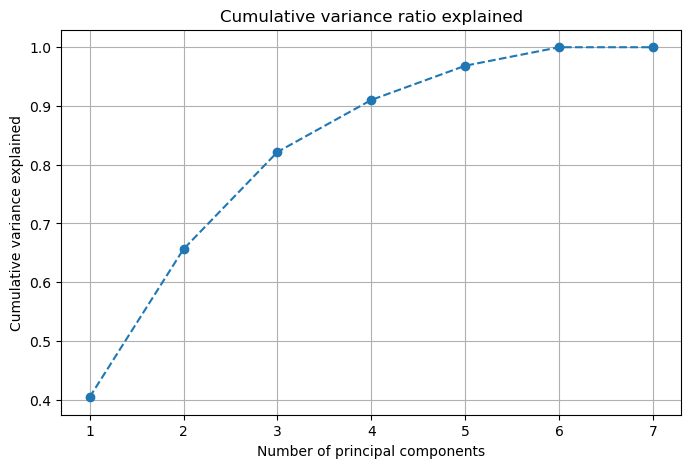

In [9]:
pca = PCA()
pca.fit(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

print("Variance ratio explained per component:")
print(explained_variance_ratio)

cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative variance ratio explained')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative variance explained')
plt.grid(True)
plt.show()

We keep 3 principal components.

In [10]:
n_components_selected = 3 
pca = PCA(n_components=n_components_selected)
X_pca = pca.fit_transform(X_scaled)

loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(n_components_selected)], 
    index=features
)

print("\n--- Loadings of variables ---")
print(loadings.round(3))


--- Loadings of variables ---
                     PC1    PC2    PC3
Income             0.525 -0.223  0.176
ApplicantIncome    0.451 -0.426 -0.116
CoapplicantIncome  0.217  0.397  0.630
LoanInstallment    0.426  0.262 -0.374
LoanAmount         0.463 -0.187  0.120
Loan_Amount_Term  -0.180 -0.395  0.612
IncomeImpact       0.214  0.593  0.172


In [11]:
n_components_selected = X_pca.shape[1] 

# List of new columns name
pca_column_names = [f'PC{i+1}' for i in range(n_components_selected)]

df_pca = pd.DataFrame(data=X_pca, columns=pca_column_names)

data = data.reset_index(drop=True)

# Join data and df_pca
data = pd.concat([data, df_pca], axis=1)


WE analyse the ROC-AUC score and the point biseral correlation for the new set of continuous variables

In [12]:
num_vars = data.select_dtypes(include=['number']).columns

for var in num_vars.drop('Loan_Status_Numeric'):
    auc = roc_auc_score(data[target], data[var])
    print(f"AUC de {var}: {auc:.3f}")
    r, p = pointbiserialr(data[target], data[var])
    print("Point biserial correlation:", r, "p-value:", p)


AUC de ApplicantIncome: 0.496
Point biserial correlation: -0.005664533941529245 p-value: 0.8919075199110303
AUC de CoapplicantIncome: 0.514
Point biserial correlation: -0.07015368481475345 p-value: 0.091981943964972
AUC de LoanAmount: 0.473
Point biserial correlation: -0.041897900060003226 p-value: 0.3146297537902582
AUC de Loan_Amount_Term: 0.487
Point biserial correlation: -0.029979491264994787 p-value: 0.4719208164358507
AUC de Income: 0.505
Point biserial correlation: -0.03717705671251498 p-value: 0.3723014829119282
AUC de LoanInstallment: 0.475
Point biserial correlation: -0.015393858271076824 p-value: 0.7118935688934084
AUC de IncomeImpact: 0.509
Point biserial correlation: -0.07797149764463353 p-value: 0.0610191465971766
AUC de PC1: 0.486
Point biserial correlation: -0.04429137410641795 p-value: 0.2877577176385543
AUC de PC2: 0.530
Point biserial correlation: -0.035946822542528414 p-value: 0.38834192690239444
AUC de PC3: 0.494
Point biserial correlation: -0.07544047302440902 p-v